In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import log2, sqrt

# Chaînes de Markov cachées et segmentation d’image

### II. Les chaînes de Markov

QUESTION 1

In [2]:
def gauss(signal_noisy, m1, sig1, m2, sig2):
    """
    Cette fonction transforme le signal bruité par les densité des deux gaussiennes du bruit
    :param signal_noisy: Le signal bruité (numpy array 1D)
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément de signal noisy
    """

    f1_array = norm.pdf(signal_noisy, m1, sig1)
    f2_array = norm.pdf(signal_noisy, m2, sig2)

    return np.array([f1_array, f2_array], dtype=float).T

QUESTION 2

In [3]:
def forward(A, p, gauss):
    """
    Cette fonction calcule récursivement (mais ce n'est pas une fonction récursive!) les valeurs forward de la chaîne
    :param A: Matrice (2*2) de transition de la chaîne
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param gauss: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément du signal bruité
    :return: un vecteur de taille la longueur de la chaîne, contenant tous les forward (de 1 à n)
    """

    n = len(gauss)
    forward_values = np.zeros((n, 2))  # Créer un tableau pour stocker les forward values
    forward_values[0] = p * gauss[0]  # Initialisation du premier pas de temps

    scaling_factors = np.zeros(n)
    scaling_factors[0] = 1 / np.sum(forward_values[0])
    forward_values[0] *= scaling_factors[0]


    for t in range(1, n):
        forward_values[t] = gauss[t] * np.dot(A.T, forward_values[t - 1])  # Calcul des forward values
        scaling_factors[t] = np.sum(forward_values[t])
        forward_values[t] /= scaling_factors[t]


    return forward_values

QUESTION 3

In [4]:
def backward(A, gauss):
    """
    Cette fonction calcule récursivement (mais ce n'est pas une fonction récursive!) les valeurs backward de la chaîne
    :param A: Matrice (2*2) de transition de la chaîne
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param gauss: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément du signal bruité
    :return: un vecteur de taille la longueur de la chaîne, contenant tous les backward (de 1 à n).
    Attention, si on calcule les backward en partant de la fin de la chaine, je conseille quand même d'ordonner le vecteur backward du début à la fin
    """

    n = len(gauss)
    backward_values = np.zeros((n, 2))  # Créer un tableau pour stocker les backward values
    backward_values[-1] = 1.0  # Initialisation du dernier pas de temps

    scaling_factors = np.zeros(n)  # Définition des facteurs d'échelle

    scaling_factors[-1] = np.sum(backward_values[-1])
    backward_values[-1] /= scaling_factors[-1]  # Normalisation du dernier pas de temps


    for t in range(n - 2, -1, -1):
        backward_values[t] = np.dot(A, gauss[t + 1] * backward_values[t + 1])  # Calcul des backward values
        scaling_factors[t] = np.sum(backward_values[t])
        backward_values[t] /= scaling_factors[t]  # Normalisation à l'aide des facteurs d'échelle

    
    return backward_values

QUESTION 4

In [5]:
def mpm_mc(signal_noisy, cl, p, A, m1, sig1, m2, sig2):
    """
     Cette fonction permet d'appliquer la méthode mpm pour retrouver notre signal d'origine à partir de sa version bruité et des paramètres du model.
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param cl: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    alpha = forward(A,p,gausses)
    beta = backward(A,gausses)

    posterior_probabilities = alpha * beta
    posterior_probabilities /= np.sum(posterior_probabilities, axis=0)
    classified_signal = np.where(posterior_probabilities.T[0] > posterior_probabilities.T[1], cl[0], cl[1])
    

    return classified_signal

QUESTION 5

In [6]:
def simu_mc(n, w, p, A):
    """
    Cette fonction permet de simuler un signal discret à 2 classe de taille n à partir des probabilité d'apparition des deux classes et de la Matrice de transition
    :param n: taille du signal
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    simu = np.zeros((n,), dtype=int)
    aux = np.random.multinomial(1, p)
    simu[0] = w[np.argmax(aux)]
    for i in range(1, n):
        aux = np.random.multinomial(1, A[np.where(w == simu[i - 1])[0][0], :])
        simu[i] = w[np.argmax(aux)]
    return simu

def bruit_gauss(signal, cl, m1, sig1, m2, sig2):
    """
    Cette fonction permet de bruiter un signal discret à deux classes avec deux gaussiennes
    :param signal: Le signal a bruiter (un numpy array d'int)
    :param cl: vecteur dont la première composante est la valeur de la classe 1 et la deuxième est la valeur de la classe 2
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: le signal bruité (numpy array de float)
    """
    return (signal == cl[0]) * np.random.normal(m1, sig1, signal.shape) + (signal == cl[1]) * np.random.normal(m2, sig2, signal.shape)

def calc_erreur(signal1, signal2):
    """
    Cette fonction permet de mesurer la difference entre deux signaux discret (de même taille) à deux classes
    :param signal1: le premier signal, un numpy array
    :param signal2: le deuxième signal, un numpy array
    :return: La différence entre les deux signaux (un float)
    """
    return np.count_nonzero(signal1!=signal2)/signal1.size

In [7]:
def markov_chain_segmentation(n, w, p, A, m1, sig1, m2, sig2):
    # Générez la chaîne de Markov
    CM = simu_mc(n, w, p, A)

    # Bruitez la chaîne de Markov
    CM_bruit = bruit_gauss(CM, w, m1, sig1, m2, sig2)

    # Segmentez le signal bruité en utilisant le MPM dans les chaînes de Markov cachées
    CM_bruit_MPM = mpm_mc(CM_bruit, w, p, A, m1, sig1, m2, sig2)

    # Calculez le taux d'erreur
    erreur = calc_erreur(CM, CM_bruit_MPM)
    
    return CM, CM_bruit, CM_bruit_MPM, erreur

QUESTION 6

Matrice de transition 1:
Bruit 1: Taux d'erreur = 0.1150
Bruit 2: Taux d'erreur = 0.1180
Bruit 3: Taux d'erreur = 0.2470
Matrice de transition 2:
Bruit 1: Taux d'erreur = 0.1470
Bruit 2: Taux d'erreur = 0.1780
Bruit 3: Taux d'erreur = 0.3050
Matrice de transition 3:
Bruit 1: Taux d'erreur = 0.0600
Bruit 2: Taux d'erreur = 0.0790
Bruit 3: Taux d'erreur = 0.1920


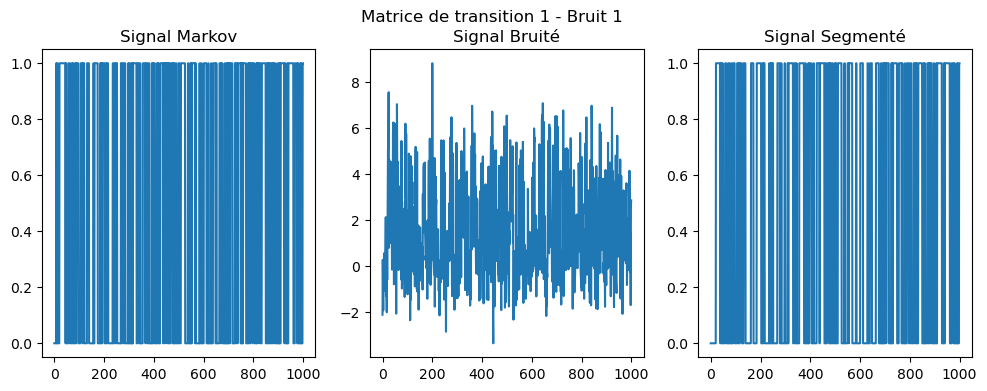

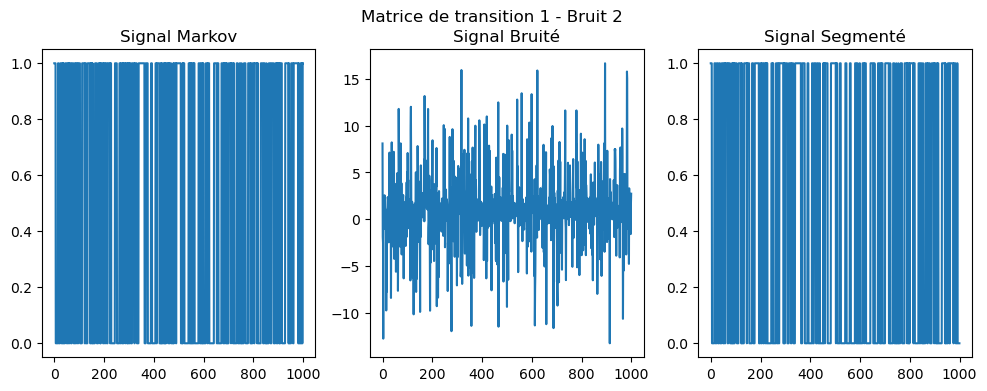

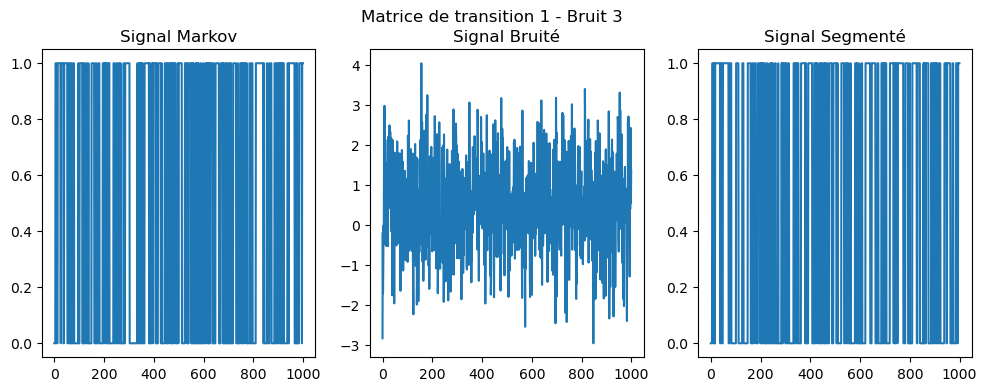

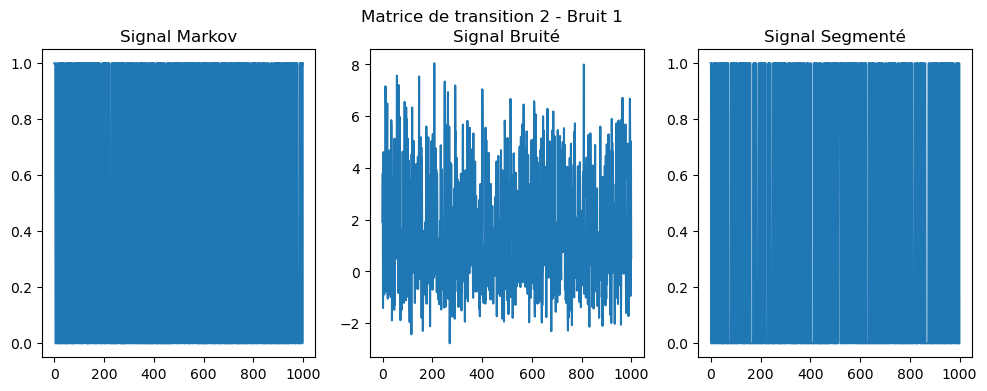

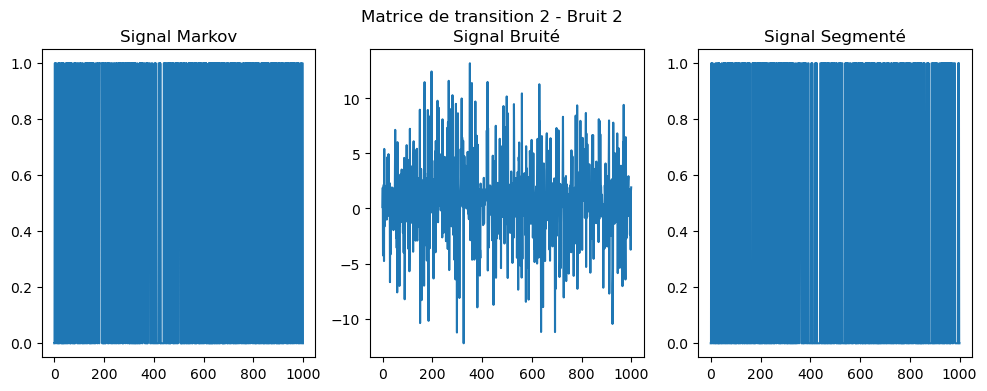

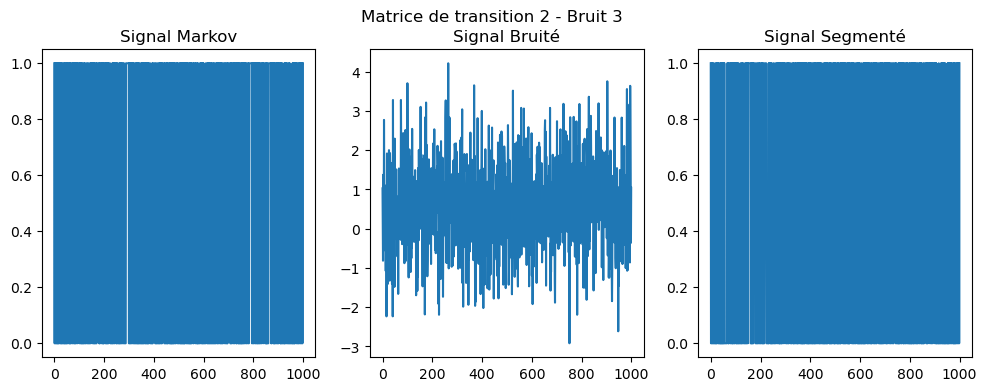

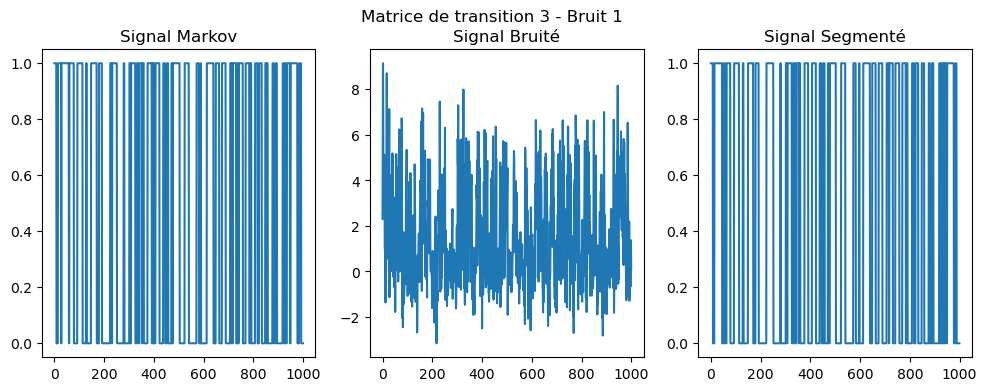

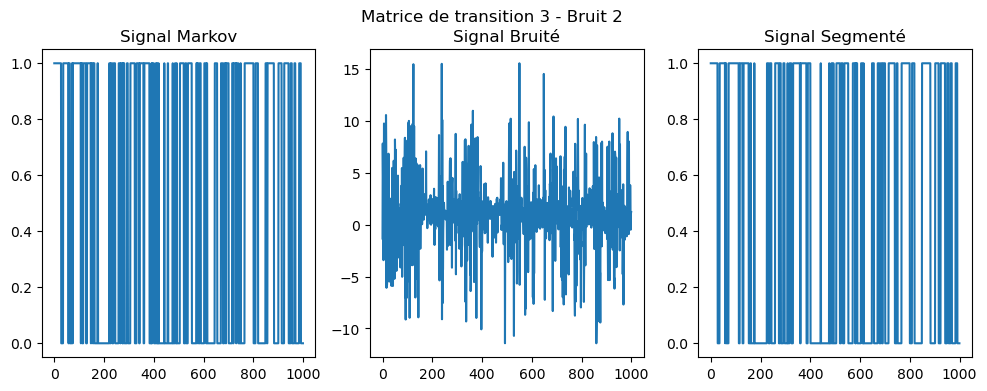

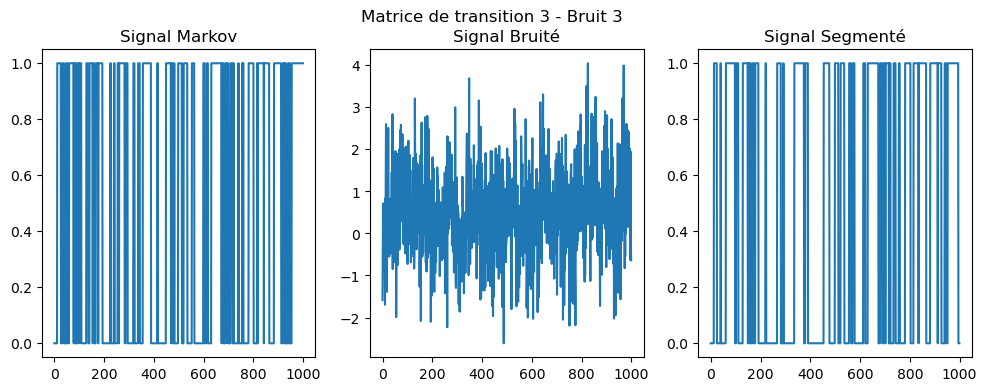

In [8]:
# Paramètres de la chaîne de Markov et paramètres du bruit
n = 1000  # Taille du signal
w = np.array([0, 1])  # Valeurs des classes
p = np.array([0.5, 0.5])  # Probabilité d'apparition a priori pour chaque classe

matrices_transition = [
    np.array([[0.8, 0.2], [0.2, 0.8]]),
    np.array([[0.6, 0.4], [0.4, 0.6]]),
    np.array([[0.9, 0.1], [0.1, 0.9]])]

parametres_bruit = [
    (0, 3, 1, 2),
    (1, 1, 1, 5),
    (0, 1, 1, 1)]


resultats = []
figures = []
for i, A in enumerate(matrices_transition):
    erreurs = []
    for j, (m1, m2, sig1, sig2) in enumerate(parametres_bruit):
        # Générez la chaîne de Markov
        CM, CM_bruit, CM_bruit_MPM, erreur = markov_chain_segmentation(n, w, p, A, m1, sig1, m2, sig2)
        erreurs.append(erreur)

        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(CM)
        plt.title("Signal Markov")
        plt.subplot(132)
        plt.plot(CM_bruit)
        plt.title("Signal Bruité")
        plt.subplot(133)
        plt.plot(CM_bruit_MPM)
        plt.title("Signal Segmenté")
        plt.suptitle(f"Matrice de transition {i + 1} - Bruit {j + 1}")
        figures.append(plt)

    resultats.append(erreurs)


# Affichez les résultats dans un tableau récapitulatif
for i, erreurs in enumerate(resultats):
    print(f"Matrice de transition {i + 1}:")
    for j, erreur in enumerate(erreurs):
        print(f"Bruit {j + 1}: Taux d'erreur = {erreur:.4f}")

Analse des résultats :

Il ressort de l'analyse des taux d'erreur que la capacité à différencier les classes se détériore avec l'augmentation de la similitude des moyennes m1 et m2, ainsi que l'égalité des variances σ1 et σ2. 

Concrètement, le Bruit 1 présente les erreurs les plus basses car les moyennes sont nettement distinctes, réduisant ainsi l'ambiguïté dans la classification. Le Bruit 2, où les moyennes sont identiques mais les variances diffèrent, se traduit par une augmentation modérée des erreurs. La configuration du Bruit 3, avec des moyennes proches et des variances identiques, présente le plus grand défi, se soldant par les taux d'erreur les plus élevés. Ces résultats soulignent l'importance de la dispersion des caractéristiques statistiques dans l'efficacité de la segmentation.

Lors de l'examen des changements de la matrice de transition, nous observons que les matrices avec des probabilités de transition plus élevées pour rester dans le même état favorisent une meilleure segmentation. Cela est particulièrement visible avec la troisième matrice de transition qui affiche des erreurs nettement inférieures aux deux autres, indiquant une meilleure cohérence dans la séquence des états cachés et, par conséquent, une segmentation plus précise.

QUESTION 7

In [9]:
def calc_probaprio_mc(signal, cl):
    """
    Cete fonction permet de calculer les probabilité a priori des classes w1 et w2 et les transitions a priori d'une classe à l'autre,
    en observant notre signal non bruité
    :param signal: Signal discret non bruité à deux classes (numpy array 1D d'int)
    :param cl: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :return: un vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    """

    n = len(signal)
    A = np.zeros((2, 2))

    # Calculer les probabilités a priori des classes
    p1 = (np.sum((signal == cl[0]))/signal.shape[0])
    p2 = (np.sum((signal == cl[1]))/signal.shape[0])
    p = np.array([p1,p2])

    # Compter les transitions de chaque classe à l'autre
    for i in range(n - 1):
        if signal[i] == cl[0] and signal[i + 1] == cl[0]:
            A[0, 0] += 1
        elif signal[i] == cl[0] and signal[i + 1] == cl[1]:
            A[0, 1] += 1
        elif signal[i] == cl[1] and signal[i + 1] == cl[0]:
            A[1, 0] += 1
        elif signal[i] == cl[1] and signal[i + 1] == cl[1]:
            A[1, 1] += 1

    # Normalisation des probabilités de transition
    A /= np.sum(A, axis=1)[:, np.newaxis]

    return p, A

QUESTION 8

In [10]:
def simu_gm(n, cl, p):
    """
    Cette fonction permet de simuler un signal discret à 2 classe de taille n àpartir des probabilité d'apparition des deux classes
    :param n: taille du signal
    :param cl: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition pour chaque classe
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    simu = np.zeros((n,), dtype=int)
    for i in range(n):
        aux = np.random.multinomial(1, p)
        simu[i] = cl[np.argmax(aux)]
    return simu

In [11]:
def mpm_gm(signal_noisy, cl, p, m1, sig1, m2, sig2):
    """
    Cette fonction permet d'appliquer la méthode mpm pour retrouver notre signal d'origine à partir de sa version bruité et des paramètres du model.
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param cl: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: Un signal discret à 2 classes (numpy array 1D d'int)
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    proba_apost = p * gausses
    proba_apost = proba_apost / (proba_apost.sum(axis=-1)[..., np.newaxis])
    return cl[np.argmax(proba_apost, axis=-1)]

In [12]:
def calc_probaprio_gm(signal, cl):
    """
    Cete fonction permet de calculer les probabilité a priori des classes w1 et w2, en observant notre signal non bruité
    :param signal: Signal discret non bruité à deux classes (numpy array 1D d'int)
    :param cl: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :return: un vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    """
    p1 = np.sum((signal == cl[0]))/signal.shape[0]
    p2 = np.sum((signal == cl[1]))/signal.shape[0]
    return np.array([p1,p2])

In [13]:
# Paramètres pour le modèle indépendant
w = np.array([1, 2], dtype=int)
p_indep = [0.25, 0.75]


# Paramètres pour la chaîne de Marko
p_markov = [0.25, 0.75]
A_markov = np.array([[0.8, 0.2], [0.07, 0.93]])
n = 1000  # Taille des signaux à générer

# Liste des bruits à utiliser
bruits = [(0, 3, 1, 2), 
          (1, 1, 1, 5), 
          (0, 1, 1, 1)]

for i, (m1, sig1, m2, sig2) in enumerate(bruits):
    print(f"Bruit {i + 1} (m1={m1}, m2={m2}, sig1={sig1}, sig2={sig2})")

    # Modèle indépendant
    signal_indep = simu_gm(n, w, p_indep)
    signal_noisy = bruit_gauss(signal_indep, w, m1, sig1, m2, sig2)
    p_markov_est, A_markov_est = calc_probaprio_mc(signal_indep, w)
    

    signal_restored_indep = mpm_gm(signal_noisy, w, p_indep, m1, sig1, m2, sig2)
    error_rate_indep = calc_erreur(signal_indep, signal_restored_indep)

    signal_restored_indep_MPM = mpm_mc(signal_noisy, w, p_markov_est, A_markov_est, m1, sig1, m2, sig2)
    error_rate_MPM = calc_erreur(signal_indep, signal_restored_indep_MPM)
    print(f"Modèle indépendant + modèle indé : Taux d'erreur = {error_rate_indep:.4f}")
    print(f"Modèle indépendant + chaine de markov : Taux d'erreur = {error_rate_MPM:.4f}")

    # Chaîne de Markov
    signal_markov = simu_mc(n, w, p_markov, A_markov)
    signal_noisy = bruit_gauss(signal_markov, w, m1, sig1, m2, sig2)
    p_indep_est = calc_probaprio_gm(signal_markov, w)

    signal_restored_markov = mpm_mc(signal_noisy, w, p_markov, A_markov, m1, sig1, m2, sig2)
    error_rate = calc_erreur(signal_markov, signal_restored_markov)

    signal_restored_indep = mpm_gm(signal_noisy, w, p_indep_est, m1, sig1, m2, sig2)
    error_rate_indep = calc_erreur(signal_markov, signal_restored_indep)

    print(f"Chaine de Markov + modèle indé : Taux d'erreur = {error_rate_indep:.4f}")
    print(f"Chaine de Markov + chaine de markov : Taux d'erreur = {error_rate_MPM:.4f}")

    print()

print("Fin de l'étude")

Bruit 1 (m1=0, m2=1, sig1=3, sig2=2)
Modèle indépendant + modèle indé : Taux d'erreur = 0.2010
Modèle indépendant + chaine de markov : Taux d'erreur = 0.2760
Chaine de Markov + modèle indé : Taux d'erreur = 0.2380
Chaine de Markov + chaine de markov : Taux d'erreur = 0.2760

Bruit 2 (m1=1, m2=1, sig1=1, sig2=5)
Modèle indépendant + modèle indé : Taux d'erreur = 0.2040
Modèle indépendant + chaine de markov : Taux d'erreur = 0.2450
Chaine de Markov + modèle indé : Taux d'erreur = 0.2060
Chaine de Markov + chaine de markov : Taux d'erreur = 0.2450

Bruit 3 (m1=0, m2=1, sig1=1, sig2=1)
Modèle indépendant + modèle indé : Taux d'erreur = 0.2260
Modèle indépendant + chaine de markov : Taux d'erreur = 0.2940
Chaine de Markov + modèle indé : Taux d'erreur = 0.2530
Chaine de Markov + chaine de markov : Taux d'erreur = 0.2940

Fin de l'étude


Analse des résultats :

Les résultats mettent en évidence une performance variable des méthodes de Maximum a Posteriori (MPM) en fonction du modèle sous-jacent du signal. Lorsque le signal est généré par un modèle indépendant, les erreurs de segmentation sont légèrement inférieures avec le MPM basé sur le modèle indépendant, comparé à celui basé sur la chaîne de Markov. Cependant, pour les signaux générés par le modèle de Markov, le MPM basé sur le modèle de Markov n'offre pas systématiquement de meilleures performances, indiquant une sensibilité du MPM à la structure du signal sous-jacent.

## III) Application à la segmentation d’images

QUESTION 1

In [14]:
def calc_param_EM_mc(signal_noisy, p, A, m1, sig1, m2, sig2):
    """
    Cette fonction permet de calculer les nouveaux paramètres estimé pour une itération de EM
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: tous les paramètres réestimés donc p, A, m1, sig1, m2, sig2
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    alpha = forward(A, p, gausses)
    beta = backward(A, gausses)
    n = len(signal_noisy)

    # Calcul de psi:
    psi = np.zeros((n-1, 2, 2))
    for k in range(n-1):
        for i in range(2):
            for j in range(2):
                psi[k,i,j] = alpha[k,i] * A[i,j] *  gausses[k+1,j] * beta[k+1,j]
    psi /= np.sum(psi, axis=(1, 2), keepdims=True)
    
    # Calcul de chsi:
    chsi = np.zeros((n, 2))
    for k in range(n):
        chsi[k, 0] = alpha[k, 0] * beta[k, 0] / (alpha[k, 0] * beta[k, 0] + alpha[k, 1] * beta[k, 1])
        chsi[k, 1] = alpha[k, 1] * beta[k, 1] / (alpha[k, 0] * beta[k, 0] + alpha[k, 1] * beta[k, 1])

    #Calcul de p:
    p = np.mean(chsi, axis = 0)

    # Calcul de A:
    A = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            A[i,j] = np.sum(psi[:,i,j])/np.sum(chsi[:,i])

    # Calcul de m1 et m2::
    m1 = np.sum(signal_noisy * chsi[:,0])/np.sum(chsi[:,0])
    m2 = np.sum(signal_noisy * chsi[:,1])/np.sum(chsi[:,1])

    #Calcul de sig1 et sig2:
    sig1 = np.sqrt(np.sum(((signal_noisy-m1)**2)*chsi[:,0])/sum(chsi[:,0]))
    sig2 = np.sqrt(np.sum(((signal_noisy-m2)**2)*chsi[:,1])/sum(chsi[:,1]))
    
    return p, A, m1, sig1, m2, sig2

In [15]:
def estim_param_EM_mc(iter, signal_noisy, p, A, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param iter: Nombre d'itérations choisi
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: la valeur d'initialisation du vecteur de proba
    :param A: la valeur d'initialisation de la matrice de transition de la chaîne
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de la variance de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de la variance de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p, A, m1, sig1, m2, sig2
    """
    p_est = p
    A_est = A
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    for i in range(iter):
        p_est, A_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_mc(signal_noisy, p_est, A_est, m1_est, sig1_est, m2_est, sig2_est)
        #print({'p':p_est, 'A':A_est, 'm1':m1_est, 'sig1':sig1_est, 'm2':m2_est, 'sig2':sig2_est})
    return p_est, A_est, m1_est, sig1_est, m2_est, sig2_est


In [16]:
def calc_param_EM_gm(signal_noisy, p, m1, sig1, m2, sig2):
    """
    Cette fonction permet de calculer les nouveaux paramètres estimé pour une itération de EM
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: tous les paramètres réestimés donc p, m1, sig1, m2, sig2
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    proba_apost = p * gausses
    proba_apost = proba_apost / (proba_apost.sum(axis=-1)[..., np.newaxis])
    p = proba_apost.sum(axis=0)/proba_apost.shape[0]
    m1 = (proba_apost[:,0] * signal_noisy).sum()/proba_apost[:,0].sum()
    sig1 = np.sqrt((proba_apost[:,0]*((signal_noisy-m1)**2)).sum()/proba_apost[:,0].sum())
    m2 = (proba_apost[:, 1] * signal_noisy).sum() / proba_apost[:, 1].sum()
    sig2 = np.sqrt((proba_apost[:, 1] * ((signal_noisy - m2) ** 2)).sum() / proba_apost[:, 1].sum())
    return p, m1, sig1, m2, sig2


def estim_param_EM_gm(iter, signal_noisy, p, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param iter: Nombre d'itération choisie
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: la valeur d'initialisation du vecteur de proba
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de la variance de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de la variance de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p, m1, sig1, m2, sig2
    """
    p_est = p
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    for i in range(iter):
        p_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_gm(signal_noisy, p_est, m1_est, sig1_est, m2_est, sig2_est)
        #print({'p':p_est, 'm1':m1_est, 'sig1':sig1_est, 'm2':m2_est, 'sig2':sig2_est})
    return p_est, m1_est, sig1_est, m2_est, sig2_est

In [17]:
def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp],dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x,y


def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0]==img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donner une image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize==int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize,dSize))
    img[idx[0], idx[1]] = signal
    return img


def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]


def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0]==img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize==int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize,dSize))
    img[idx[0], idx[1]] = signal
    return img

QUESTION 2

erreur_markov =0.426116943359375, erreur_ind = 0.4685516357421875


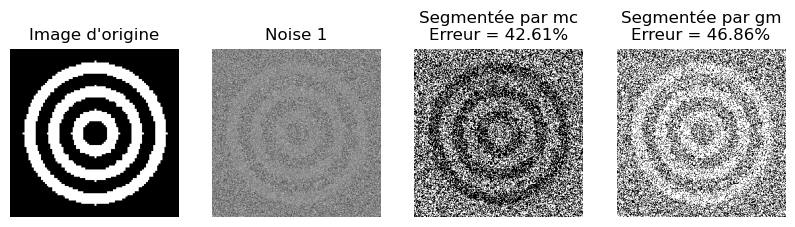

erreur_markov =0.32733154296875, erreur_ind = 0.121917724609375


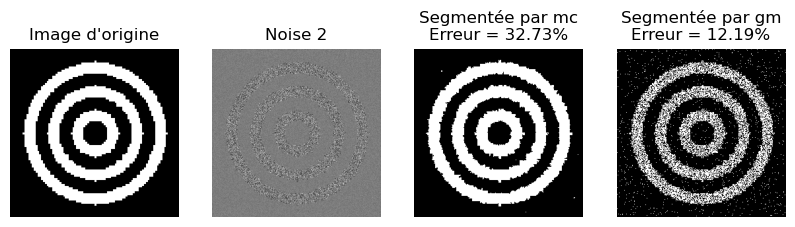

erreur_markov =0.3099365234375, erreur_ind = 0.3284149169921875


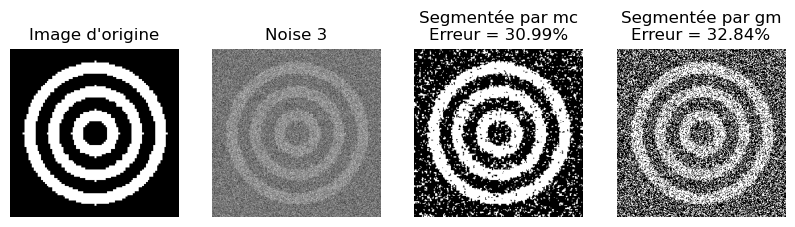

erreur_markov =0.40570068359375, erreur_ind = 0.4518890380859375


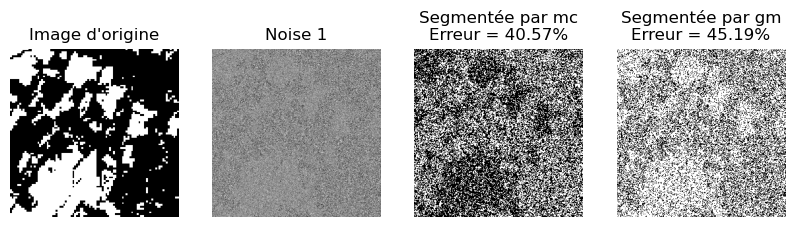

erreur_markov =0.3795928955078125, erreur_ind = 0.137542724609375


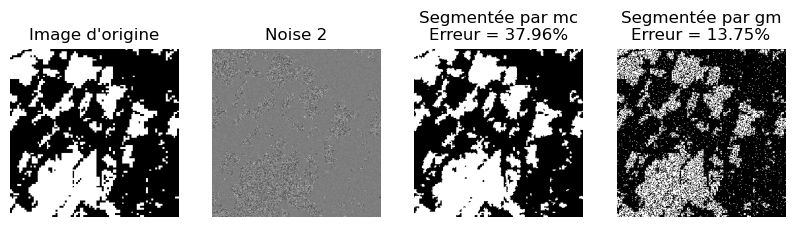

erreur_markov =0.4208984375, erreur_ind = 0.3115386962890625


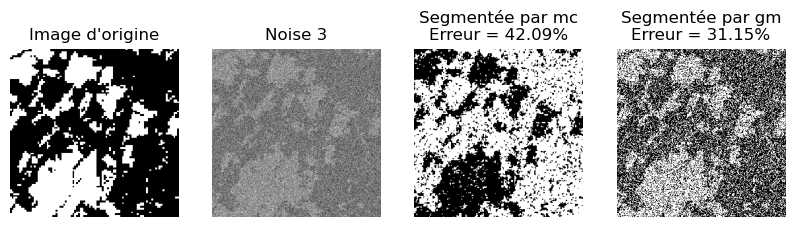

erreur_markov =0.463531494140625, erreur_ind = 0.4246978759765625


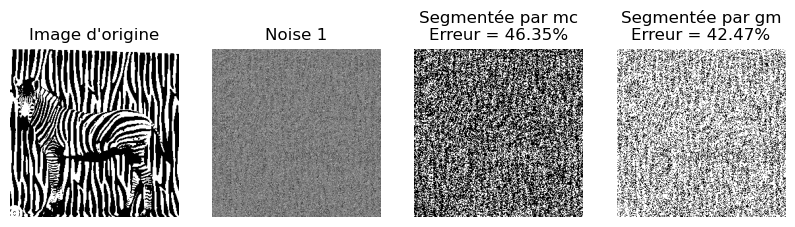

erreur_markov =0.4509124755859375, erreur_ind = 0.16302490234375


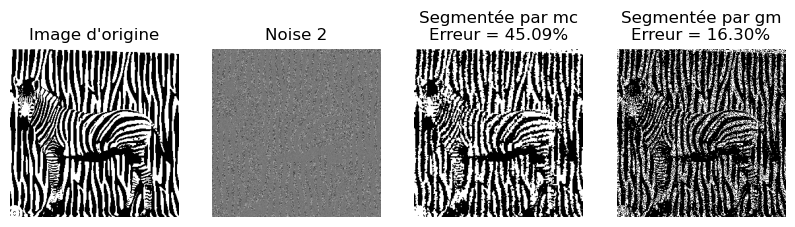

erreur_markov =0.4304351806640625, erreur_ind = 0.306243896484375


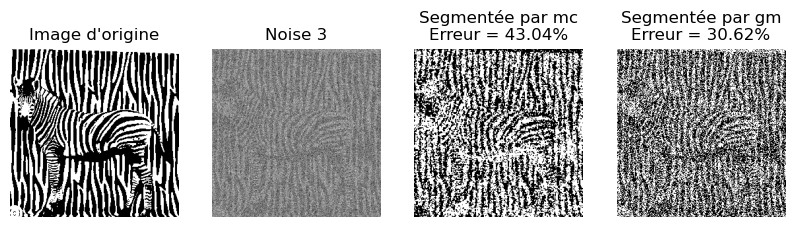

In [21]:
bruits = [[0, 3, 1, 2], 
          [1, 1, 1, 5], 
          [0, 1, 1, 1]]


img_1 = 'images/alpha2.bmp', 'images/beee2.bmp', 'images/cible2.bmp'
img_2 = 'images/country2.bmp', 'images/promenade2.bmp', 'images/veau2.bmp'
img_3 = 'images/zebre2.bmp', 'images/cit2.bmp'

images = ['images/cible2.bmp', 'images/country2.bmp', 'images/zebre2.bmp' ]

for img_file in images:
    img = cv.imread(img_file, cv.IMREAD_GRAYSCALE)
    img_flat = peano_transform_img(img)
    cl = np.array(sorted(list(set(img_flat))))


    for i, (m1, sig1, m2, sig2) in enumerate(bruits):
        img_flat_noisy = bruit_gauss(img_flat, cl, m1, sig1, m2, sig2)

        kmeans = KMeans(n_clusters=2, random_state=0, n_init=100).fit(img_flat_noisy.reshape(-1, 1))
        labels = kmeans.labels_
        kmeans_classes = np.array(sorted(list(set(labels))))
        p_init, A_init = calc_probaprio_mc(labels, kmeans_classes)

        m1_init = img_flat_noisy[np.where(labels == kmeans_classes[0])].mean()
        sig1_init = img_flat_noisy[np.where(labels == kmeans_classes[0])].std()
        m2_init = img_flat_noisy[np.where(labels == kmeans_classes[1])].mean()
        sig2_init = img_flat_noisy[np.where(labels == kmeans_classes[1])].std()

        iter_em = 20


        ### Classification par la méthode du MPM chaîne de Markov : ###
        p_est_mc, A_est_mc, m1_est_mc, sig1_est_mc, m2_est_mc, sig2_est_mc = estim_param_EM_mc(iter_em, img_flat_noisy, p_init, A_init, m1_init, sig1_init, m2_init, sig2_init)
        signal_restored_markov = mpm_mc(img_flat_noisy, cl, p_est_mc, A_est_mc, m1_est_mc, sig1_est_mc, m2_est_mc, sig2_est_mc)
        erreur_markov = calc_erreur(labels, signal_restored_markov)
        if erreur_markov > 0.5: #Si l'erreur est trop élevé on inverse les couleurs
                    signal_restored_markov = np.where(signal_restored_markov == cl[0], cl[1], np.where(signal_restored_markov == cl[1], cl[0], signal_restored_markov))
                    erreur_markov = 1-erreur_markov

        seg_markov_img = transform_peano_in_img(signal_restored_markov, img.shape[0])



        ### Classification par la méthode du MPM gaussian mixture : ###
        p_est_ind, m1_est_ind, sig1_est_ind, m2_est_ind, sig2_est_ind = estim_param_EM_gm(iter_em, img_flat_noisy, p_init, m1_init, sig1_init, m2_init, sig2_init)
        signal_restored_ind = mpm_gm(img_flat_noisy, cl, p_est_ind, m1_est_ind, sig1_est_ind, m2_est_ind, sig2_est_ind)
        erreur_ind = calc_erreur(img_flat, signal_restored_ind)
        if erreur_ind > 0.5: #Si l'erreur est trop élevé on inverse les couleurs
                    signal_restored_ind = np.where(signal_restored_ind == cl[0], cl[1], np.where(signal_restored_ind == cl[1], cl[0], signal_restored_ind))
                    erreur_ind = 1-erreur_ind

        seg_ind_img = transform_peano_in_img(signal_restored_ind, img.shape[0])



        print(f"erreur_markov ={erreur_markov}, erreur_ind = {erreur_ind}")
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Image d\'origine')
        ax1.axis('off')
        ax2.imshow(transform_peano_in_img(img_flat_noisy, int(sqrt(len(img_flat)))), cmap='gray')
        ax2.set_title(f'Noise {i+1}')
        ax2.axis('off')
        ax3.imshow(seg_markov_img, cmap='gray')
        ax3.set_title(f'Segmentée par mc\nErreur = {erreur_markov:.2%}')
        ax3.axis('off')
        ax4.imshow(seg_ind_img, cmap='gray')
        ax4.set_title(f'Segmentée par gm\nErreur = {erreur_ind:.2%}')
        ax4.axis('off')
        plt.show()

Il est important de noter que dans les cas où le taux d'erreur dépasse 50%, cela pourrait suggérer que le modèle de segmentation a inversé les classes de pixels. Cela peut se produire lorsqu'il y a une grande incertitude ou une symétrie dans la distribution des classes, rendant l'algorithme de segmentation incapable de distinguer correctement l'avant-plan de l'arrière-plan. Dans la pratique, cette situation exige une intervention manuelle pour corriger l'inversion des classes, ce qui peut être considéré comme un inconvénient dans des scénarios d'application réels où l'image d'origine n'est pas connue pour orientation.

Analyse des résultats :

Les résultats obtenus dans cette partie du TP montrent des écarts significatifs par rapport à ceux de la première partie. Bien que l'on s'attendait à ce que les modèles de segmentation se comportent de manière similaire face aux différents types de bruits, les variations des taux d'erreur suggèrent que d'autres facteurs peuvent influencer la performance.

Une hypothèse pour expliquer cette différence pourrait être une possible divergence dans l'implémentation des modèles entre les deux parties du TP. Des erreurs subtiles dans le code, des différences dans les paramètres utilisés pour les modèles, ou même des variations dans la manière dont les bruits sont générés et appliqués aux images pourraient entraîner des différences dans les taux d'erreur observés.

Par exemple, pour le Bruit 2, où le modèle indépendant a montré une supériorité notable dans la dernière partie du TP, il est possible que le modèle markovien n'ait pas été correctement ajusté pour tenir compte de la distribution spécifique du bruit, ou que l'application du bruit n'ait pas conservé les caractéristiques statistiques attendues. De même, les taux d'erreur similaires entre les modèles pour le Bruit 3 pourraient indiquer une mauvaise calibration des hypothèses markoviennes ou indépendantes sous-jacentes aux méthodes de segmentation.